In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

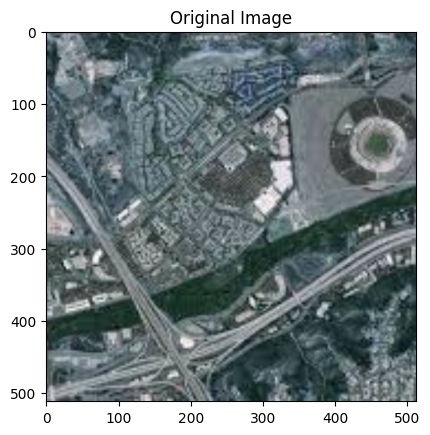

In [2]:
def resize_and_crop_center(image_path, crop_width, crop_height):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found.")

    image_height, image_width = image.shape[:2]
    if image_width < crop_width or image_height < crop_height:
        scale = max(crop_width / image_width, crop_height / image_height)
        new_width, new_height = int(image_width * scale), int(image_height * scale)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    start_x = center_x - crop_width // 2
    start_y = center_y - crop_height // 2
    return image[start_y:start_y + crop_height, start_x:start_x + crop_width]

image = resize_and_crop_center('/content/drive/MyDrive/Image Project/airbus.jpeg', 512, 512)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

In [3]:
def periodic_pad(x, pad_length):
    # Pads signal x periodically by pad_length on both sides
    return np.concatenate((x[-pad_length:], x, x[:pad_length]))

In [4]:
def dwt_1d(signal, h0, h1, mode='periodic'):
    """
    Perform a single-level 1D DWT using filters h0 (low-pass) and h1 (high-pass).
    mode: 'periodic' extension.
    """
    length = len(signal)
    filter_length = len(h0)
    half_len = filter_length // 2

    if mode == 'periodic':
        # Periodic padding to handle border effects
        # We'll pad so we can always apply filters starting at index
        signal_pad = periodic_pad(signal, half_len)
    else:
        raise NotImplementedError("Only 'periodic' mode is implemented for demonstration.")

    # Convolve and downsample
    # Approximation coefficients
    a = []
    # Detail coefficients
    d = []

    for n in range(length // 2):
        # Index in the padded signal:
        idx = 2*n  # downsampling factor = 2
        segment = signal_pad[idx:idx+filter_length]
        a_val = np.sum(segment * h0)
        d_val = np.sum(segment * h1)
        a.append(a_val)
        d.append(d_val)

    return np.array(a), np.array(d)

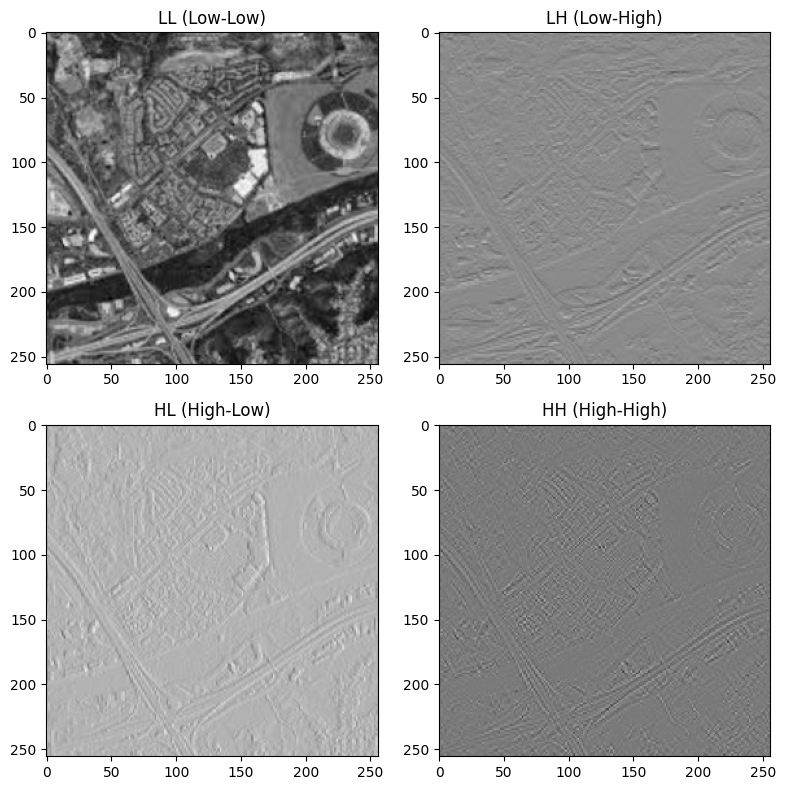

In [5]:
def dwt2(data, wavelet='haar', mode='periodic'):
    """
    Manual single-level 2D DWT using the Haar (db1) wavelet.
    data: 2D numpy array
    wavelet: only 'haar' implemented here, but you could extend for other wavelets
    mode: 'periodic' for simplicity
    """
    # Define Haar filters
    if wavelet == 'haar' or wavelet == 'db1':
        h0 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
        h1 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
    else:
        raise ValueError("Only 'haar' (db1) supported in this manual implementation.")

    # Step 1: Decompose each row
    rows = data.shape[0]
    cols = data.shape[1]

    # Apply 1D DWT along rows
    low_rows = []
    high_rows = []
    for r in range(rows):
        a, d = dwt_1d(data[r, :], h0, h1, mode=mode)
        low_rows.append(a)
        high_rows.append(d)
    low_rows = np.array(low_rows)   # shape: (rows, cols/2)
    high_rows = np.array(high_rows) # shape: (rows, cols/2)

    # Step 2: Decompose columns of low_rows and high_rows
    # We do 1D DWT along columns now.
    def dwt_along_columns(matrix, h0, h1, mode='periodic'):
        # matrix: (rows, cols)
        # We'll apply DWT along each column and produce two matrices: A and D
        r, c = matrix.shape
        A_cols = []
        D_cols = []
        for col_i in range(c):
            col_data = matrix[:, col_i]
            a, d = dwt_1d(col_data, h0, h1, mode=mode)
            A_cols.append(a)
            D_cols.append(d)
        A_cols = np.array(A_cols).T  # shape: (rows/2, cols)
        D_cols = np.array(D_cols).T  # shape: (rows/2, cols)
        return A_cols, D_cols

    # Decompose the approximation part (low_rows)
    cA, cV = dwt_along_columns(low_rows, h0, h1, mode=mode)
    # Decompose the detail part (high_rows)
    cH, cD = dwt_along_columns(high_rows, h0, h1, mode=mode)

    return cA, (cH, cV, cD)

cA, (cH, cV, cD) = dwt2(gray)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1), plt.imshow(cA, cmap='gray'), plt.title('LL (Low-Low)')
plt.subplot(2, 2, 2), plt.imshow(cV, cmap='gray'), plt.title('LH (Low-High)')
plt.subplot(2, 2, 3), plt.imshow(cH, cmap='gray'), plt.title('HL (High-Low)')
plt.subplot(2, 2, 4), plt.imshow(cD, cmap='gray'), plt.title('HH (High-High)')
plt.tight_layout()
plt.show()

In [6]:
def idwt_1d(a, d, mode='periodic'):
    """
    Inverse 1D Haar DWT.
    Given approximation (a) and detail (d) coefficients,
    reconstruct the original signal.
    """
    # For Haar:
    # x[2i]   = (a[i] + d[i]) / sqrt(2)
    # x[2i+1] = (a[i] - d[i]) / sqrt(2)
    length = a.size + d.size
    x = np.zeros(length, dtype=np.float64)
    for i in range(a.size):
        x[2*i]   = (a[i] + d[i]) / np.sqrt(2)
        x[2*i+1] = (a[i] - d[i]) / np.sqrt(2)
    return x

In [7]:
def idwt_along_columns(A_cols, D_cols, mode='periodic'):
    """
    Inverse DWT along columns of matrices.
    Given A_cols and D_cols that represent a column-wise decomposition,
    reconstruct the original matrix.
    A_cols and D_cols are 2D arrays of shape (rows/2, cols).
    """
    rows_recon = A_cols.shape[0] * 2
    cols = A_cols.shape[1]
    recon = np.zeros((rows_recon, cols), dtype=np.float64)

    for c in range(cols):
        a_col = A_cols[:, c]
        d_col = D_cols[:, c]
        col_data = idwt_1d(a_col, d_col, mode=mode)
        recon[:, c] = col_data
    return recon

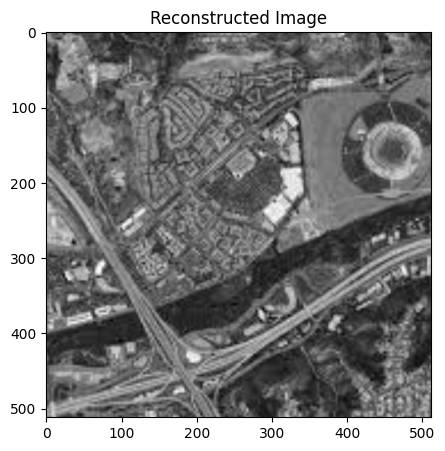

In [8]:
def idwt2_manual(cA, cH, cV, cD, wavelet='haar', mode='periodic'):
    """
    Manual single-level inverse 2D DWT using the Haar (db1) wavelet.
    This inverts the operation done by dwt2_manual.

    Parameters
    ----------
    cA, cH, cV, cD : 2D np.arrays
        The approximation and detail coefficients from a single-level 2D DWT.
    wavelet : str
        'haar' (db1) supported in this manual implementation.
    mode : str
        'periodic' extension only.

    Returns
    -------
    data : 2D np.array
        The reconstructed image (or 2D data array).
    """
    # The forward transform did:
    # rows -> separate low_rows and high_rows
    # columns on low_rows -> cA, cV
    # columns on high_rows -> cH, cD
    #
    # Inverse steps:
    # 1) Combine cA and cV along columns to get low_rows
    # 2) Combine cH and cD along columns to get high_rows
    # 3) Combine low_rows and high_rows along rows to get original data

    # Step 1: Inverse column-wise transform for low frequencies (cA,cV)
    low_rows = idwt_along_columns(cA, cV, mode=mode)

    # Step 2: Inverse column-wise transform for high frequencies (cH,cD)
    high_rows = idwt_along_columns(cH, cD, mode=mode)

    # Step 3: Now combine low_rows and high_rows along each row (inverse of row DWT)
    data = np.zeros((low_rows.shape[0], low_rows.shape[1]*2), dtype=np.float64)
    rows = low_rows.shape[0]

    for r in range(rows):
        a = low_rows[r, :]
        d = high_rows[r, :]
        # Inverse 1D DWT along the row direction
        # a, d each length C/2 -> reconstruct a row of length C
        row_reconstructed = (a + d)/np.sqrt(2)
        row_reconstructed_even = (a - d)/np.sqrt(2)

        # Combine even and odd samples
        # Actually, to properly invert:
        # x_even = (a[i] + d[i]) / sqrt(2)
        # x_odd  = (a[i] - d[i]) / sqrt(2)
        # Let's do this using a standard idwt_1d if you have it:

        # If using the idwt_1d function:
        # row_reconstructed = idwt_1d(a, d, mode='periodic')

        # Without a function, manually:
        C = a.size * 2
        row_rec = np.zeros(C)
        for i in range(a.size):
            row_rec[2*i]   = (a[i] + d[i])/np.sqrt(2)
            row_rec[2*i+1] = (a[i] - d[i])/np.sqrt(2)

        data[r, :] = row_rec

    return data

reconstructed_image = idwt2_manual(cA, cH, cV, cD)

plt.figure(figsize=(15, 5))
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

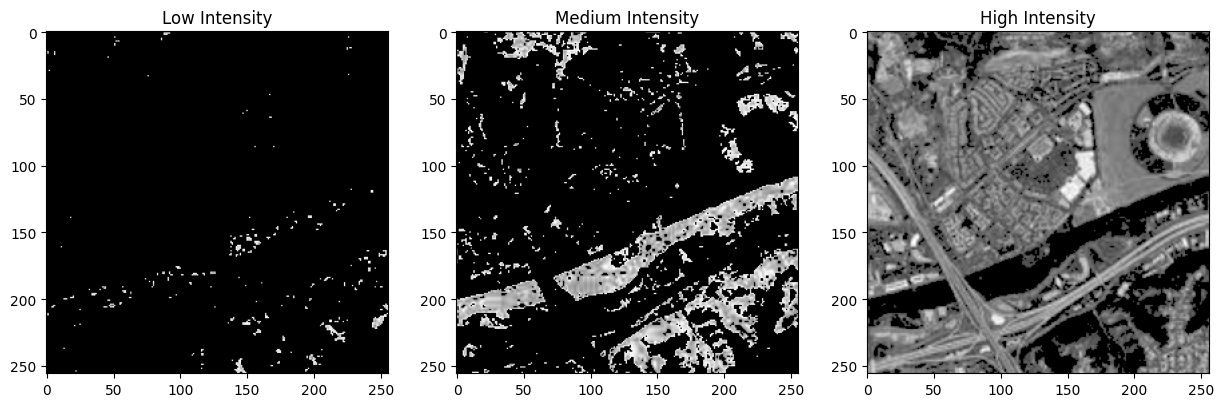

In [9]:
def brightness_level_analysis(LL):
    """
    Perform brightness level analysis on the LL subband.
    """
    log_avg = np.exp(np.mean(np.log(LL + 1e-5)))
    low_bound, high_bound = 0.4, 0.7
    low_layer = LL * (LL < low_bound * log_avg)
    middle_layer = LL * ((LL >= low_bound * log_avg) & (LL <= high_bound * log_avg))
    high_layer = LL * (LL > high_bound * log_avg)

    return low_layer, middle_layer, high_layer

low_layer, middle_layer, high_layer = brightness_level_analysis(cA)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(low_layer, cmap='gray')
plt.title(f'Low Intensity')

plt.subplot(132)
plt.imshow(middle_layer, cmap='gray')
plt.title(f'Medium Intensity')

plt.subplot(133)
plt.imshow(high_layer, cmap='gray')
plt.title(f'High Intensity')

plt.show()

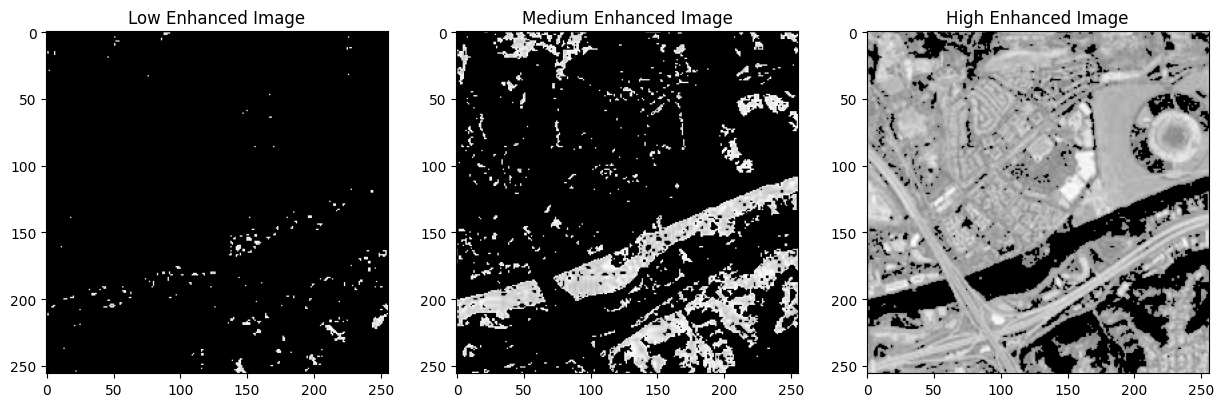

In [10]:
def adaptive_intensity_transformation(layer, gamma=0.5):
    """
    Apply adaptive intensity transformation (gamma correction).
    """
    layer = layer / np.max(layer)  # Normalize

    return np.power(layer, gamma) * 255

low_enhanced = adaptive_intensity_transformation(low_layer)
middle_enhanced = adaptive_intensity_transformation(middle_layer)
high_enhanced = adaptive_intensity_transformation(high_layer)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(low_enhanced, cmap='gray')
plt.title('Low Enhanced Image')

plt.subplot(132)
plt.imshow(middle_enhanced, cmap='gray')
plt.title('Medium Enhanced Image')

plt.subplot(133)
plt.imshow(high_enhanced, cmap='gray')
plt.title('High Enhanced Image')

plt.show()

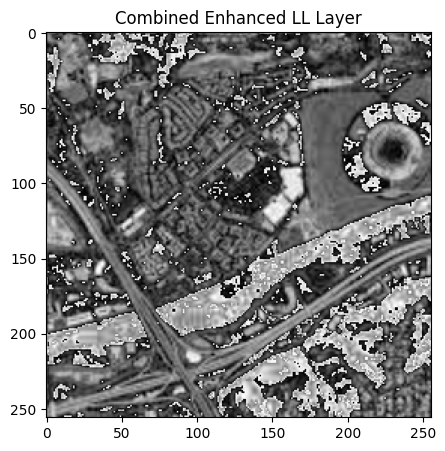

In [11]:
def combine_layers(low, middle, high):
    """
    Combine enhanced low, middle, and high intensity layers.
    """
    return cv2.addWeighted(low, 0.33, middle, 0.33, 0) + high * 0.33

enhanced_LL = combine_layers(low_enhanced, middle_enhanced, high_enhanced)

plt.figure(figsize=(15, 5))
plt.imshow(enhanced_LL, cmap='gray')
plt.title('Combined Enhanced LL Layer')
plt.show()

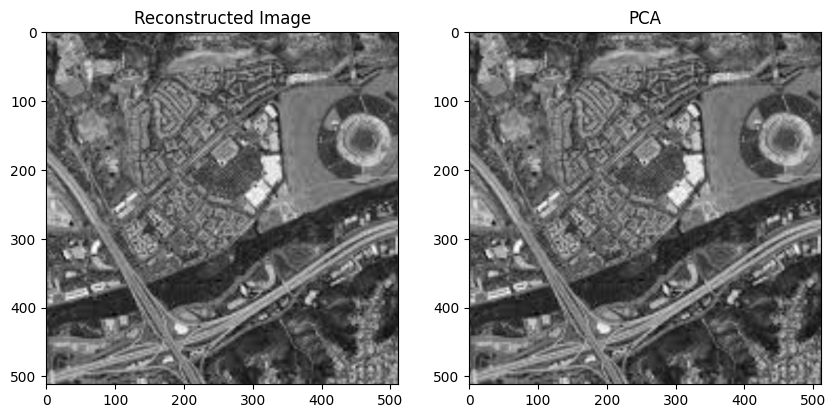

In [18]:
def manual_pca(image):
    """
    Perform manual Principal Component Analysis (PCA) on a grayscale image.
    """
    h, w = image.shape
    flat_image = image.reshape(-1, 1).astype(np.float32)

    # Compute mean and subtract it
    mean = np.mean(flat_image, axis=0)
    centered_data = flat_image - mean

    # Covariance matrix
    covariance = np.dot(centered_data.T, centered_data) / (flat_image.shape[0] - 1)

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(covariance)

    # Select the principal component
    principal_component = eigenvectors[:, np.argmax(eigenvalues)]

    # Project data onto principal component
    projected = np.dot(centered_data, principal_component)

    # Reconstruct the image
    reconstructed = np.dot(projected[:, np.newaxis], principal_component[np.newaxis, :]) + mean
    return reconstructed.reshape(h, w)

final_image = manual_pca(gray)

# Normalize the output for visualization
# final_image = cv2.normalize(final_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(reconstructed_image, cmap='gray'), plt.title('Reconstructed Image')
plt.subplot(122), plt.imshow(final_image, cmap='gray'), plt.title('PCA')
plt.show()

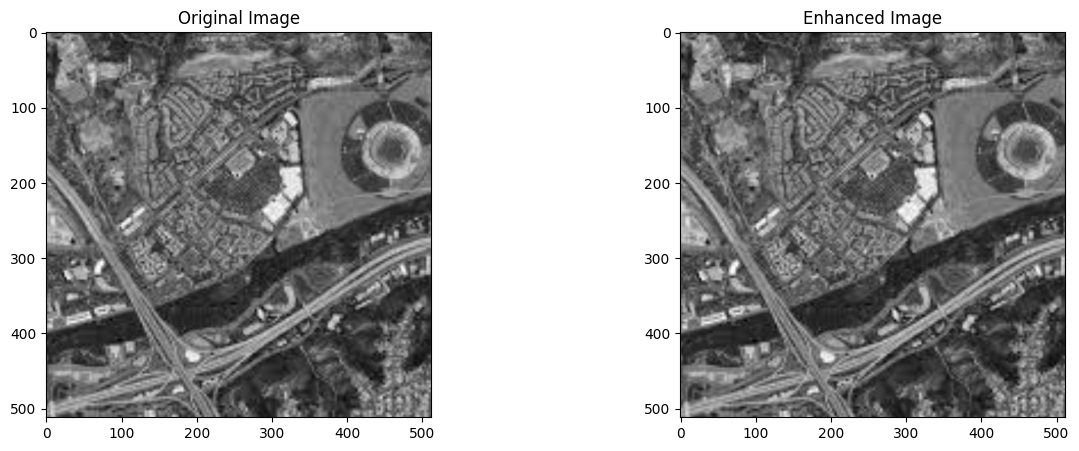

True

In [13]:
# Main Function
def enhance_image(image_path, crop_width, crop_height):
    # Step 1: Preprocess the image
    image = resize_and_crop_center(image_path, 512, 512)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Manual DWT Decomposition
    cA, (cH, cV, cD) = dwt2(gray)

    # Step 3: Brightness Level Analysis
    low_layer, middle_layer, high_layer = brightness_level_analysis(cA)

    # Step 4: Adaptive Intensity Transformation
    low_enhanced = adaptive_intensity_transformation(low_layer)
    middle_enhanced = adaptive_intensity_transformation(middle_layer)
    high_enhanced = adaptive_intensity_transformation(high_layer)

    # Step 5: Combine Layers
    enhanced_LL = combine_layers(low_enhanced, middle_enhanced, high_enhanced)

    # Step 6: Manual Inverse DWT
    reconstructed_image = idwt2_manual(cA, cH, cV, cD)

    # Step 7: Apply Manual PCA
    final_image = manual_pca(reconstructed_image)

    # Normalize the output for visualization
    final_image = cv2.normalize(final_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display the result

    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Image')

    plt.subplot(122)
    plt.imshow(final_image, cmap='gray')
    plt.title('Enhanced Image')
    plt.show()
    return final_image

# Example usage

input_image_path = "/content/drive/MyDrive/Image Project/airbus.jpeg"
enhanced_output = enhance_image(input_image_path, crop_width=512, crop_height=512)
cv2.imwrite("enhanced_output.jpg", enhanced_output)



In [14]:
def max_abs_diff(a, b):
  return np.max(np.abs(a - b))

print(max_abs_diff(gray, enhanced_output))
print(gray)
print('--------------------------')
print(enhanced_output)
print('--------------------------')
print(gray - enhanced_output)

255
[[140 138 135 ...  77  74  70]
 [140 138 135 ...  77  74  70]
 [143 144 142 ...  73  70  70]
 ...
 [155 151 147 ... 106  87 101]
 [154 144 138 ... 103  81  92]
 [154 144 138 ... 103  81  92]]
--------------------------
[[ 87 151 141 ... 125  98  75]
 [ 64 137 135 ...  73  71  68]
 [ 64 137 135 ...  73  71  68]
 ...
 [106 154 156 ... 125 105  87]
 [ 96 153 148 ... 125 102  82]
 [ 87 151 141 ... 125  98  75]]
--------------------------
[[ 53 243 250 ... 208 232 251]
 [ 76   1   0 ...   4   3   2]
 [ 79   7   7 ...   0 255   2]
 ...
 [ 49 253 247 ... 237 238  14]
 [ 58 247 246 ... 234 235  10]
 [ 67 249 253 ... 234 239  17]]
